In [1]:
import numpy as np
import os
from scipy.io import loadmat
from scipy.signal import butter,filtfilt
import scipy.signal as sg
import plotly as py
import plotly.graph_objs as go
from plotly import tools
from scipy.fftpack import fft, ifft
from plotly.subplots import make_subplots

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
py.offline.init_notebook_mode(connected=True)

%matplotlib inline
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
#preprocessors

import scipy.io as sio

import mne
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.decoding import CSP




def inputmat(fp):
    """load .mat file and return m as a dict"""
    mat = sio.loadmat(fp, squeeze_me=True)
    td = {}  # create a dict

    # Numpy array of size channel_num * points.
    td['data'] = mat['cnt'].T  # data
    td['freq'] = mat['nfo']['fs'][True][0]  # Sampling frequency

    # channel names are necessary information for creating a rawArray.
    td['ch_names'] = mat['nfo']['clab'][True][0]

    # Position of channels
    
    td['electrode_x'] = mat['nfo']['xpos'][True][0]
    td['electrode_y'] = mat['nfo']['ypos'][True][0]

    #make trials by finding trials and its data
    td['cue'] = mat['mrk']['pos'][True][0] #time of cue
    td['labels'] = mat['mrk']['y'][True][0] #labels of the data
    return td


def creatEventsArray(fp):
    """Create events array. The second column default to zero."""
    td = inputmat(fp)
    events = np.zeros((td['labels'].size, 3), int) #here we have made a matrix type array of the size of label.size*3
#     print(events)
    events[:, 0] = td['cue']  # The first column is the sample number of the event.
#     print(events[:, 0])
    events[:, 2] = td['labels']  # The third column is the new event value.
#     print(events[:, 2])
    return events, td['labels']


def create_info(td):
    """Create MNE info object from the dataset dictionary"""
    ch_names = td['ch_names'].tolist()  # Channel names
    ch_types = ['eeg'] * len(ch_names)  # Assuming all channels are EEG

    # Assuming z-coordinate is set to 0 for all electrodes
    electrode_positions = np.column_stack([td['electrode_x'], td['electrode_y'], np.zeros(len(ch_names))])
    # fix electrode positions by scaling them
    electrode_positions = electrode_positions * 0.1
    # Create a montage using electrode positions
    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, electrode_positions)),
                                            coord_frame='head')

    # Create info object without the montage
    info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=td['freq'])

    # Set the montage
    info.set_montage(montage)

    return info

def creatRawArray(fp):
    """Create a mne.io.RawArray object, data: array, shape (n_channels, n_times)"""
    td = inputmat(fp)
    
    # info = mne.create_info(ch_names, td['freq'], 'eeg')  # Create info for raw
    info = create_info(td)
    raw = mne.io.RawArray(td['data'], info, first_samp=0, copy='auto', verbose=None)
    return raw




In [3]:
# Where to save the figures

"""
image relation with dpi and resolution

https://stackoverflow.com/questions/47633546/relationship-between-dpi-and-figure-size

"""

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification_png_ex"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=660):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

from mne.decoding import CSP
from mne.channels import read_layout

In [5]:
"""The files c, d, e are the artificial data so we can test out our labels in different ways in them"""


file1 = r'Data/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1a_1000Hz.mat'
file2 = r'Data/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1b_1000Hz.mat'

# artificial data files

file3 = r'Data/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1c_1000Hz.mat'
file4 = r'Data/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1d_1000Hz.mat'
file5 = r'Data/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1e_1000Hz.mat'
file6 = r'Data/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1f_1000Hz.mat'
file7 = r'Data/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1g_1000Hz.mat'



"""making the file dictionary and channel dictionary for easy pickup"""
fp = {
    'ds1a': file1,
    'ds1b': file2,
    'ds1f': file6,
    'ds1g': file7,
}



""" Pick channels if necessary but not needed as we will be deploying a CSP pipeline ahead"""


low_freq, high_freq = 7., 30.
tmin, tmax = 0., 3.5

event_id = {'left': -1, 'foot': 1}

In [6]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

In [7]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50, 150, 0, 1])   

In [8]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    #plt.xlabel('Flase positive Rate (Fall-out)', Fontsize=16)
    #plt.ylabel('True positive Rate (Recall)', Fontsize=16)
    plt.grid(True)

In [9]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.


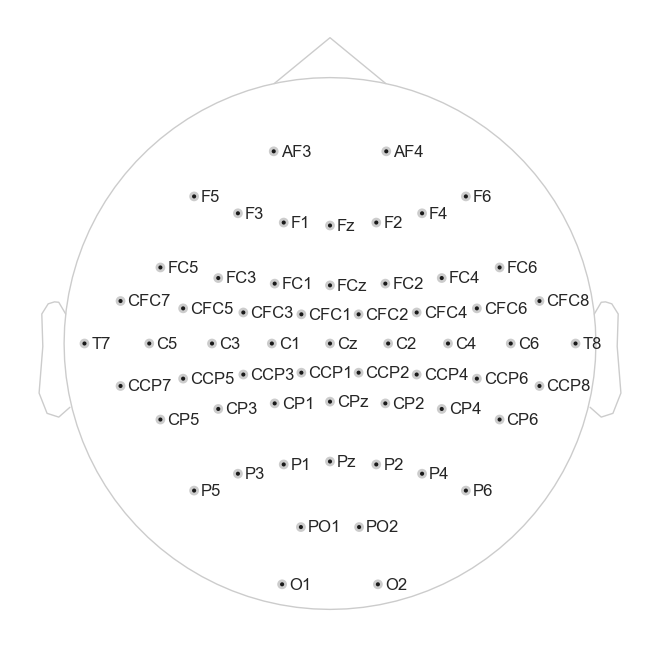

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Label dimensions:
(200,)
<Info | 8 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 dig: 62 items (3 Cardinal, 59 EEG)
 highpass: 7.0 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 1000.0 Hz
>
Shape of epochs data:
(160, 59, 1001)
Shape of labels:
(160,)
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.


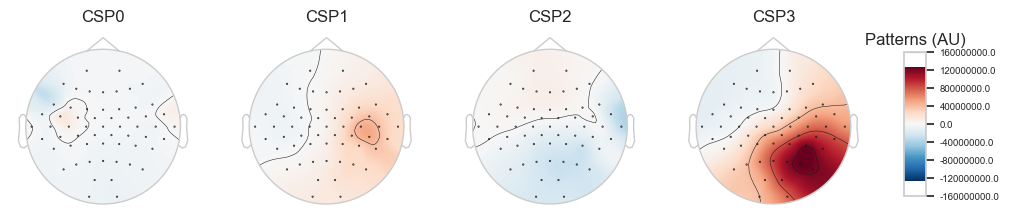

Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None


/Users/mohamed/Documents/University/Graduation Project/Optimized-BCI/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None


/Users/mohamed/Documents/University/Graduation Project/Optimized-BCI/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None


/Users/mohamed/Documents/University/Graduation Project/Optimized-BCI/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: ra

/Users/mohamed/Documents/University/Graduation Project/Optimized-BCI/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None


/Users/mohamed/Documents/University/Graduation Project/Optimized-BCI/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



    Using tolerance 2e+03 (2.2e-16 eps * 59 dim * 1.5e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e+03 (2.2e-16 eps * 59 dim * 1.6e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None


/Users/mohamed/Documents/University/Graduation Project/Optimized-BCI/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



    Using tolerance 2e+03 (2.2e-16 eps * 59 dim * 1.5e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e+03 (2.2e-16 eps * 59 dim * 1.6e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL


KeyboardInterrupt: 

In [15]:
"""code from the mne documentation
https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html"""

#this is the MLP neural net classifier
from sklearn.neural_network import MLPClassifier
from mne.channels import make_standard_montage

for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])    
    # Use set_montage to apply the montage
    raw.plot_sensors(show_names=True)
    # montage = make_standard_montage('standard_1005')
    # raw.set_montage(montage)
    # Assuming `raw` is your Raw object
    info = raw.info
    # Continue with your processing, e.g., filtering, epoching, and classification
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
    

    # event_train = eventsTrain(fp[f])
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    print("Label dimensions:")
    print(labels.shape)

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    MLP_C = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 16), random_state=42)
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    
    print(info)

    print("Shape of epochs data:")
    print(X_train.shape)
    print("Shape of labels:")
    print(y_train.shape)

    csp.fit(X_train, y_train)
    csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)



    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('MLP_C', MLP_C)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    # Training the model
    clf.fit(X_train, y_train_copy)
    # Predicting output values
    pred = clf.predict(X_test)


    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    # print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    # print(y_test_copy)

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print('Predictions are as follows: ')
    print(pred)
    print("Actual values are as follows")
    print(y_test_copy)

    print('__________________________________________________________________________________')
    
    #new territory from here
    y_probas = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='predict_proba')
    
    y_test_dfs = y_probas[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)